In [1]:
!pip install -U tensorflow-text==2.6.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 19.3 MB/s 
     |████████████████████████████████| 570.3 MB 353 bytes/s 
     |████████████████████████████████| 5.6 MB 27.9 MB/s 
     |████████████████████████████████| 14.8 MB 59.4 MB/s 
     |████████████████████████████████| 1.3 MB 61.6 MB/s 
     |████████████████████████████████| 462 kB 50.5 MB/s 
     |████████████████████████████████| 132 kB 73.8 MB/s 
  Created wheel for clang: filename=clang-5.0-py3-none-any.whl size=30694 sha256=538ce45fc4755d240aa64692c6a1f991ca9a96f3bacc356213826aa41d36ff74
  Stored in directory: /root/.cache/pip/wheels/98/91/04/971b4c587cf47ae952b108949b46926f426c02832d120a082a
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68726 sha256=5116c186bc3035ae603eeafd373fe15172a7b2b37bf97ab87ebe0ca0f70484c3
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd

In [3]:
from google.colab import drive 
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [50]:
dataset_pos = pd.read_csv("/content/gdrive/MyDrive/positives.csv")
dataset_pos['Category'] = 'Disease'
dataset_neg = pd.read_csv("/content/gdrive/MyDrive/negatives.csv")
dataset_neg['Category'] = 'Non-Disease'
dataset = pd.concat([dataset_pos,dataset_neg])
del dataset['Label']

In [51]:
dataset['Category'].value_counts()

Non-Disease    10000
Disease         3692
Name: Category, dtype: int64

In [53]:
df_disease = dataset[dataset['Category']=='Disease']
df_nondisease = dataset[dataset['Category']=='Non-Disease']

In [54]:
df_nondisease_downsampled = df_nondisease.sample(df_disease.shape[0])

In [55]:
df_balanced = pd.concat([df_disease, df_nondisease_downsampled])
df_balanced["Category"].value_counts()

Disease        3692
Non-Disease    3692
Name: Category, dtype: int64

In [56]:
df_balanced['Label']=df_balanced['Category'].apply(lambda x: 1 if x=='Disease' else 0)

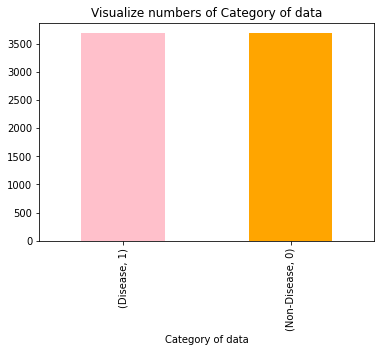

In [59]:
df_balanced.groupby('Category').Label.value_counts().plot(kind = "bar", color = ["pink", "orange", "red", "yellow", "blue"])
plt.xlabel("Category of data")
plt.title("Visualize numbers of Category of data")
plt.show()

In [58]:
df_balanced.sample(5)

,Unnamed: 0,Sentence,Category,Label
9,9,Lymphangiomas are malformations of the lymphat...,Disease,1
1643,1643,Hereditary stomatocytosis describes a number o...,Disease,1
732,732,Akriti Kakkar (Bengali: আকৃতি কক্কর) (born 7 A...,Non-Disease,0
889,889,Cor triatriatum (or triatrial heart) is a cong...,Disease,1
3622,3622,"Wolf–Hirschhorn syndrome (WHS), also known as ...",Disease,1


In [11]:
del df_balanced['Unnamed: 0']

In [12]:
df_balanced['Sentence'] = df_balanced['Sentence'].astype(str)

In [13]:
df_balanced.sample(5)

,Sentence,Category,Label
8304,Peter Barrett designed and provided the artwor...,Non-Disease,0
1560,Myocardial infarction (MI) or acute myocardial...,Disease,1
2213,"James Barrett ""Jim"" Yardley (born June 18, 196...",Non-Disease,0
1878,Doron Sheffer (Hebrew: דורון שפר‎; born 12 Mar...,Non-Disease,0
3063,"Rotor syndrome, also called Rotor type hyperbi...",Disease,1


In [14]:
df_balanced.dtypes

Sentence    object
Category    object
Label        int64
dtype: object

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(df_balanced['Sentence'],df_balanced['Label'], stratify=df_balanced['Label'])

In [17]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [18]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        {'input_type_ids': ( 0           text[0][0]                       
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      {'sequence_output':  109482241   keras_layer[0][0]                
                                                                 keras_layer[0][1]                
                                                                 keras_layer[0][2]                
______________________________________________________________________________________________

In [22]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
 loss='binary_crossentropy',
 metrics=METRICS)

In [23]:
history = model.fit(X_train, y_train, epochs=10)

Epoch 1/10
174/174 [==============================] - 71s 394ms/step - loss: 0.1699 - accuracy: 0.9657 - precision: 0.9640 - recall: 0.9675
Epoch 2/10
174/174 [==============================] - 67s 383ms/step - loss: 0.1190 - accuracy: 0.9711 - precision: 0.9684 - recall: 0.9740
Epoch 3/10
174/174 [==============================] - 67s 388ms/step - loss: 0.0981 - accuracy: 0.9769 - precision: 0.9762 - recall: 0.9776
Epoch 4/10
174/174 [==============================] - 66s 381ms/step - loss: 0.0859 - accuracy: 0.9807 - precision: 0.9805 - recall: 0.9809
Epoch 5/10
174/174 [==============================] - 67s 386ms/step - loss: 0.0819 - accuracy: 0.9791 - precision: 0.9777 - recall: 0.9805
Epoch 6/10
174/174 [==============================] - 66s 382ms/step - loss: 0.0768 - accuracy: 0.9787 - precision: 0.9783 - recall: 0.9791
Epoch 7/10
174/174 [==============================] - 67s 385ms/step - loss: 0.0720 - accuracy: 0.9801 - precision: 0.9801 - recall: 0.9801
Epoch 8/10
174/174 [

In [28]:
history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall'])

In [29]:
print('Accuracy: {acc}, Precision: {precision}, Recall: {recall}'.format(
        acc=history['accuracy'][-1], precision=history['precision'][-1], recall=history['recall'][-1]))

Accuracy: 0.9823040962219238, Precision: 0.980568528175354, Recall: 0.9841097593307495


In [30]:
# Save model.
model.save('/content/gdrive/MyDrive/Disease_classification_bert.h5')

In [31]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

In [32]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)

array([0, 0, 0, ..., 0, 1, 0])

In [33]:
print(y_predicted)

[0 0 0 ... 0 1 0]


In [39]:
y_predicted.dtype

dtype('int64')

In [40]:
y_test.dtype

dtype('int64')

In [41]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [42]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(y_test, y_predicted))

The test accuracy is: 
0.9848320693391116


In [43]:
# Classification report
print("Classification report")
print(classification_report(y_test, y_predicted))

Classification report
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       923
           1       0.98      0.99      0.98       923

    accuracy                           0.98      1846
   macro avg       0.98      0.98      0.98      1846
weighted avg       0.98      0.98      0.98      1846



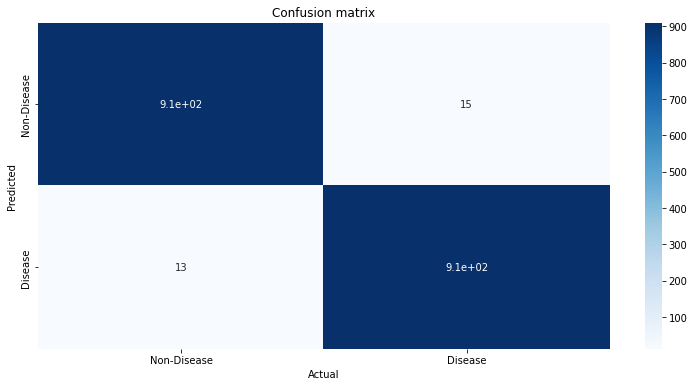

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
aux_df = df_balanced[['Category', 'Label']].drop_duplicates().sort_values('Label')
conf_matrix = confusion_matrix(y_test, y_predicted)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['Category'].values, 
            yticklabels=aux_df['Category'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

In [45]:
sample_dataset = [
  'Malaria is a mosquito-borne infectious disease that affects humans and other animals. Malaria causes symptoms that typically include fever, tiredness, vomiting, and headaches. In severe cases, it can cause jaundice, seizures, coma, or death.',
  'The Central Board of Secondary Education (CBSE) is a national level board of education in India for public and private schools, controlled and managed by the Government of India.'
]

In [47]:
sample_pred = model.predict(sample_dataset)
print(sample_pred)

[[0.95171607]
 [0.03419689]]
